***Links***
* Multi label classification - loss function - https://keras.io/examples/nlp/multi_label_classification/

In [1]:
# importing relevant libraries
import numpy as np
import pandas as pd

from stellargraph import StellarGraph, StellarDiGraph, datasets, utils
from stellargraph.mapper import FullBatchNodeGenerator, RelationalFullBatchNodeGenerator, HinSAGENodeGenerator
from sklearn import model_selection
from stellargraph.layer import RGCN, HinSAGE
from tensorflow import keras

import warnings
from time import time
from IPython.display import display, HTML
warnings.filterwarnings('ignore')
from functools import wraps

In [2]:
# file paths
hcc_mappings_fp = "/workspaces/graphs/graphs-eda/data/metadata/2022 Midyear_Final ICD-10-CM Mappings.csv"
ip_data_fp = "/workspaces/graphs/graphs-eda/data/patient-data/df_preprocessed.csv"
op_data_fp = "/workspaces/graphs/graphs-eda/data/patient-data/df_outpatient.csv"
hcc_weights_fp = "../graphs-eda/data/metadata/hcc_weights_categorised.csv"

In [3]:
# helper functions
def timed(f):
  @wraps(f)
  def wrapper(*args, **kwds):
    start = time()
    result = f(*args, **kwds)
    elapsed = time() - start
    print(f"{f.__name__} function executed. [Time taken: {round(elapsed, 3)} seconds]")
    return result
  return wrapper

In [13]:
class ICDEmbeddingGraph:
    """
    This class contains methods, attributes and functions to 
    create the following from IP and OP data -
    1. Graph object
    2. Node features
    3. Edge features
    4. Node labels
    5. Utility functions for data exploration
    """

    def __init__(self, ip_data_fp, op_data_fp, hcc_mappings_fp, threshold=2):
        """Upon instantiation prepares IP and OP data for
        processing, creates nodes and edges and stores the 
        information in pandas.Dataframe objects, and prepares
        ICD-HCC-mapping table.

        Args:
            ip_data_fp (str): IP data file path
            op_data_fp (str): OP data file path
            hcc_mappings_fp (str): ICD-HCC mappings file path
        """
        self.train_size = 0.9
        self.layer_sizes = [32, 16]
        self.activations = ['relu', 'relu']
        self.dropout = 0.25
        self.patience = 20
        self.batch_size = 50,
        self.num_samples = [7, 5]

        self.__hcc_mappings_columns__ = [
            'Diagnosis Code', 'Description', 'CMS-HCC Model Category V24']
        self.__ip_data_columns__ = [
            'empi', 'visit_id', 'visit_start_date', 'primary_diagnosis']
        self.__op_data_columns__ = ['empi', 'visit_id',
                                    'last_date_of_service', 'primary_diagnosis']
        self.threshold = threshold
        self.ip_data_fp = ip_data_fp
        self.op_data_fp = op_data_fp
        self.hcc_mappings_fp = hcc_mappings_fp
        self._prepare_hcc_mappings()
        self._prepare_patient_data()
        self._prepare_combined_data()
        self._create_icd_to_icd_edges()
        self._create_icd_nodes()
        self._create_patient_nodes()
        self._create_icd_to_patient_edges()
        self._create_edge_table()
        self.create_patient_node_labels()
    
    @timed
    def _prepare_hcc_mappings(self):
        """
        Reads, cleans and prepares the HCC metadata file
        """
        # reading the risk adjustment metadata file
        hcc_mappings = pd.read_csv(self.hcc_mappings_fp)

        # cleaning the risk adjustment metadata file
        hcc_mappings = hcc_mappings.iloc[2:-7, :]
        hcc_mappings.replace(r'\n', ' ', regex=True, inplace=True)
        hcc_mappings.reset_index(drop=True, inplace=True)

        # creating the cleaned risk adjustment metadata dataframe
        hcc_mappings_ = pd.DataFrame(hcc_mappings.iloc[1:, :])
        hcc_mappings_.columns = hcc_mappings.iloc[0, :].tolist()

        # filtering only the required columns from patient data and metadata
        hcc_mappings_ = hcc_mappings_.loc[:, self.__hcc_mappings_columns__]
        hcc_mappings_.columns = ['pd', 'dscr', 'hcc']
        hcc_mappings_.loc[:, "hcc"] = hcc_mappings_.hcc.fillna(0).astype('int')

        self.hcc_mappings = hcc_mappings_.copy()
        del hcc_mappings_
    
    @timed
    def _prepare_patient_data(self):
        """
        Reads and filters only the required columns from inpatient and outpatient data
        """
        # reading the inpatient and outpatient data
        ip_data = pd.read_csv(self.ip_data_fp)
        op_data = pd.read_csv(self.op_data_fp)

        ip_data = ip_data.loc[:, self.__ip_data_columns__]
        op_data = op_data.loc[:, self.__op_data_columns__]

        ip_data.columns = ['empi', 'vid', 'vdt', 'pd']
        op_data.columns = ['empi', 'vid', 'vdt', 'pd']

        ip_data = ip_data.merge(self.hcc_mappings[['pd','hcc']], how='left').fillna(0)
        op_data = op_data.merge(self.hcc_mappings[['pd','hcc']], how='left').fillna(0)

        self.ip_data = ip_data.copy()
        self.op_data = op_data.copy()

        del ip_data, op_data

    @timed
    def _prepare_combined_data(self):
        data = pd.concat([self.ip_data, self.op_data], axis=0)
        self.data = data.reset_index(drop=True).\
                            sort_values(['empi', 'vdt']).\
                                reset_index(drop=True).\
                                    copy()
        del data

    @timed
    def _create_icd_to_icd_edges(self):
        """creates edge-table from data
        method can be 'jaccard' or 'sum'

        Args:
            data (_type_): _description_

        Returns:
            _type_: _description_
        """        
        edge_data_icd = self.data.copy()
        edge_data_icd["pd_nxt"] = edge_data_icd.pd.shift(-1)
        index_drop = edge_data_icd.groupby('empi').tail(1).index
        edge_data_icd = edge_data_icd.drop(index_drop)
        edge_data_icd['edge'] = edge_data_icd.pd + ", " + edge_data_icd.pd_nxt
        edge_data_icd['cnt'] = 1
        edge_data_icd = edge_data_icd.groupby(['pd', 'pd_nxt'], as_index=False).agg({'cnt': 'count'})
        edge_data_icd.columns = ['source', 'target', 'weight']

        # removing sparse icd nodes
        edge_data_icd = self.remove_sparse_nodes(edge_data_icd)

        # normalise out-edge weights for a given node by the max out-edge for that node
        edge_max_weights = edge_data_icd.groupby('source', as_index=False).aggregate({'weight':'max'})
        edge_max_weights.columns=['source','max_weight']
        edge_data_icd = edge_data_icd.merge(edge_max_weights, how='left')
        edge_data_icd['weight'] = edge_data_icd.weight/edge_data_icd.max_weight
        edge_data_icd['edge_type'] = 'progresses_to'
        edge_data_icd.drop('max_weight', axis=1, inplace=True)
        

        # filtering only the edges connected to nodes that have in as well as out-edges
        self.common_pds = set(edge_data_icd.source).intersection(set(edge_data_icd.target))
        filter1 = edge_data_icd.source.isin(self.common_pds)
        filter2 = edge_data_icd.target.isin(self.common_pds)
        edge_data_icd = edge_data_icd[filter1 & filter2].reset_index(drop=True)

        self.data = self.data[self.data.pd.isin(self.common_pds)].reset_index(drop=True)
        
        self.edge_data_icd = edge_data_icd.copy()
        del edge_data_icd

    @timed
    def _create_icd_nodes(self):
        """
        Creates node table from data
        """
        self.node_data_icd = pd.DataFrame(index=self.data.pd.unique())

    @timed
    def _create_icd_to_patient_edges(self):
        """
        
        """
        self.edge_data_patient = self.data[['pd','empi']].rename({'pd':'target','empi':'source'}, axis=1)
        self.edge_data_patient = self.edge_data_patient[['source', 'target']]
        self.edge_data_patient['weight'] = 1
        self.edge_data_patient['edge_type'] = 'diagnosed_in'
        self.edge_data_patient = self.edge_data_patient[self.edge_data_patient.source.isin(self.node_data_patient.index)]

    @timed
    def _create_patient_nodes(self):
        self.node_data_patient = pd.DataFrame(index=self.data.empi.unique())
    
    @timed
    def _create_edge_table(self):
        self.edge_data = pd.concat([self.edge_data_icd, self.edge_data_patient], axis=0)[['source','target','edge_type','weight']].reset_index(drop=True)
    
    @timed
    def remove_sparse_nodes(self, edge_data_icd):
        """
        Removes edges having weight less than n 
        """
        return edge_data_icd[edge_data_icd.weight>=self.threshold].reset_index(drop=True).copy()

    @timed
    def create_icd_node_features(self):
        """Create OHE node features

        Args:
            node_data_icd (_type_): _description_
            edge_data_icd (_type_): _description_
        """
        node_data_icd = self.node_data_icd.copy()
        node_data_icd['pd'] = node_data_icd.index
        self.node_data_icd = pd.concat(
            [self.node_data_icd, pd.get_dummies(node_data_icd.pd)], axis=1)
        del node_data_icd
    
    @timed
    def create_patient_node_features(self):
        # randomly initilise the node-features
        node_data = self.node_data_patient.copy()
        num_features = 8
        for i in range(num_features):
            node_data[f'f_{i+1}'] = np.random.rand(1, node_data.shape[0])[0]
        self.node_data_patient = node_data.copy()
        del node_data
    
    @timed
    def create_patient_node_labels(self):
        data_y = self.data.copy()
        for hcc in set(self.hcc_mappings.hcc.unique()) - set(data_y.hcc.unique()):
            data_y.loc[data_y.shape[0]] = ['temp']*(data_y.shape[1]-1) +  [hcc]
        data_y = pd.concat([data_y.empi, pd.get_dummies(data_y.hcc)], axis=1).groupby(['empi']).aggregate('sum')
        data_y = data_y.drop('temp', axis=0).drop(0.0, axis=1)
        self.node_labels = (data_y>0)*1
        self.node_labels = self.node_labels.reset_index()[self.node_labels.reset_index().empi.isin(self.node_data_patient.index)]
        self.node_labels.index = self.node_labels.empi
        self.node_labels.drop(['empi'], axis=1, inplace=True)

    @timed
    def create_stellargraph(self):
        self.G = StellarGraph({
            "icd":self.node_data_icd,
            "patient":self.node_data_patient}, 
            edges=self.edge_data,
            edge_type_column='edge_type')

    @timed
    def create_trainer(self):
        self._train_test_split()
        self._create_data_generator()
        self._create_gnn()

    @timed
    def _train_test_split(self):
        self.train_subjects, self.test_subjects = model_selection.train_test_split(
            self.node_labels,
            train_size=self.train_size
        )
        self.train_targets = np.array(self.train_subjects)
        self.test_targets = np.array(self.test_subjects)

    @timed
    def _create_data_generator(self):
        self.generator = HinSAGENodeGenerator(
            self.G,
            batch_size=self.batch_size[0],
            num_samples=self.num_samples,
            head_node_type='patient'
        )
        self.train_gen = self.generator.flow(
            self.train_subjects.index, self.train_targets, shuffle=True)
        self.test_gen = self.generator.flow(
            self.test_subjects.index, self.test_targets)

    @timed
    def _create_gnn(self):
        self.rgcn = HinSAGE(
            layer_sizes=self.layer_sizes,
            activations=self.activations,
            generator=self.generator,
            bias=False,
            dropout=self.dropout,
        )
        self.x_inp, self.x_out = self.rgcn.in_out_tensors()
        self.prediction = keras.layers.Dense(
            units=self.train_targets.shape[1], activation="sigmoid")(self.x_out)
        self.model = keras.Model(inputs=self.x_inp, outputs=self.prediction)
        self.model.compile(
            optimizer=keras.optimizers.Adam(lr=0.003),
            loss='binary_crossentropy',
            metrics=["acc"],
        )
        self.es_callback = keras.callbacks.EarlyStopping(
            monitor="val_acc", patience=self.patience, restore_best_weights=True)

    @timed
    def train_gnn(self, epochs=1000):
        self.history = self.model.fit(
            self.train_gen,
            epochs=epochs,
            validation_data=self.test_gen,
            verbose=2,
            shuffle=False,
            callbacks=[self.es_callback],
        )

    @timed
    def plot_history(self):
        utils.plot_history(self.history)


In [5]:
# trainer.model.summary()

In [6]:
# del trainer

In [14]:
trainer = ICDEmbeddingGraph(ip_data_fp, op_data_fp, hcc_mappings_fp)


_prepare_hcc_mappings function executed. [Time taken: 0.185 seconds]
_prepare_patient_data function executed. [Time taken: 1.193 seconds]
_prepare_combined_data function executed. [Time taken: 0.261 seconds]
remove_sparse_nodes function executed. [Time taken: 0.004 seconds]
_create_icd_to_icd_edges function executed. [Time taken: 0.43 seconds]
_create_icd_nodes function executed. [Time taken: 0.016 seconds]
_create_patient_nodes function executed. [Time taken: 0.017 seconds]
_create_icd_to_patient_edges function executed. [Time taken: 0.065 seconds]
_create_edge_table function executed. [Time taken: 0.067 seconds]
create_patient_node_labels function executed. [Time taken: 0.875 seconds]


In [15]:
trainer.create_icd_node_features()
trainer.create_patient_node_features()
trainer.create_patient_node_labels()

create_icd_node_features function executed. [Time taken: 0.069 seconds]
create_patient_node_features function executed. [Time taken: 0.004 seconds]
create_patient_node_labels function executed. [Time taken: 0.922 seconds]


In [16]:
"""
N1
3-in-edge , N out edges
out-edge - 1-10, 15/15, 10, 1/15
"""

'\nN1\n3-in-edge , N out edges\nout-edge - 1-10, 15/15, 10, 1/15\n'

In [17]:
trainer.create_stellargraph()
print(trainer.G.info())

create_stellargraph function executed. [Time taken: 0.41 seconds]
StellarGraph: Undirected multigraph
 Nodes: 14440, Edges: 412399

 Node types:
  patient: [11177]
    Features: float32 vector, length 8
    Edge types: patient-diagnosed_in->icd
  icd: [3263]
    Features: float32 vector, length 3263
    Edge types: icd-diagnosed_in->patient, icd-progresses_to->icd

 Edge types:
    icd-diagnosed_in->patient: [389686]
        Weights: all 1 (default)
        Features: none
    icd-progresses_to->icd: [22713]
        Weights: range=[5.2017e-05, 1], mean=0.193228, std=0.354498
        Features: none


In [18]:
trainer.create_trainer()

_train_test_split function executed. [Time taken: 0.019 seconds]
_create_data_generator function executed. [Time taken: 0.074 seconds]
_create_gnn function executed. [Time taken: 0.124 seconds]
create_trainer function executed. [Time taken: 0.217 seconds]


In [19]:
trainer.train_gnn()

Epoch 1/1000
202/202 - 13s - loss: 0.3280 - acc: 0.0553 - val_loss: 0.1566 - val_acc: 0.1038
Epoch 2/1000
202/202 - 14s - loss: 0.1300 - acc: 0.0927 - val_loss: 0.1093 - val_acc: 0.1038
Epoch 3/1000
202/202 - 12s - loss: 0.1062 - acc: 0.0927 - val_loss: 0.0983 - val_acc: 0.1038
Epoch 4/1000
202/202 - 12s - loss: 0.0991 - acc: 0.0929 - val_loss: 0.0938 - val_acc: 0.1038
Epoch 5/1000
202/202 - 12s - loss: 0.0955 - acc: 0.0934 - val_loss: 0.0909 - val_acc: 0.1082
Epoch 6/1000
202/202 - 12s - loss: 0.0926 - acc: 0.1087 - val_loss: 0.0882 - val_acc: 0.1288
Epoch 7/1000
202/202 - 12s - loss: 0.0900 - acc: 0.1403 - val_loss: 0.0858 - val_acc: 0.1762
Epoch 8/1000
202/202 - 12s - loss: 0.0877 - acc: 0.1688 - val_loss: 0.0838 - val_acc: 0.1887
Epoch 9/1000
202/202 - 13s - loss: 0.0856 - acc: 0.1839 - val_loss: 0.0816 - val_acc: 0.2057
Epoch 10/1000
202/202 - 12s - loss: 0.0834 - acc: 0.2054 - val_loss: 0.0800 - val_acc: 0.2379
Epoch 11/1000
202/202 - 11s - loss: 0.0820 - acc: 0.2140 - val_loss: 

KeyboardInterrupt: 

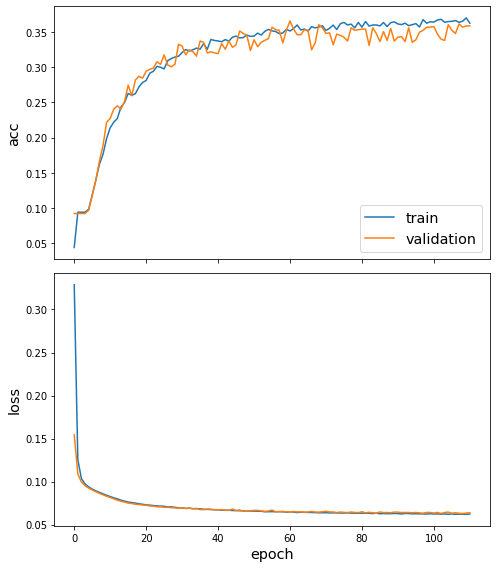

In [ ]:
utils.plot_history(trainer.history)

In [20]:
from sklearn.manifold import TSNE

embedding_model = keras.Model(inputs=trainer.x_inp, outputs=trainer.x_out)
all_nodes = trainer.node_labels.index
all_mapper = trainer.generator.flow(all_nodes)
embeddings = embedding_model.predict(all_mapper)
embeddings = pd.DataFrame(embeddings, columns=[f"X{i}" for i in np.arange(16)],index=trainer.node_labels.index)

In [21]:
transform = TSNE(n_components=2)  # dimensionality reduction
emb_tsne = pd.DataFrame(transform.fit_transform(
    embeddings), index=trainer.node_labels.index, columns=[f"X{i}" for i in np.arange(2)])
emb_tsne.index.name = 'empi'

In [49]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering

clustering = KMeans(
        n_clusters=12).fit(embeddings.to_numpy())

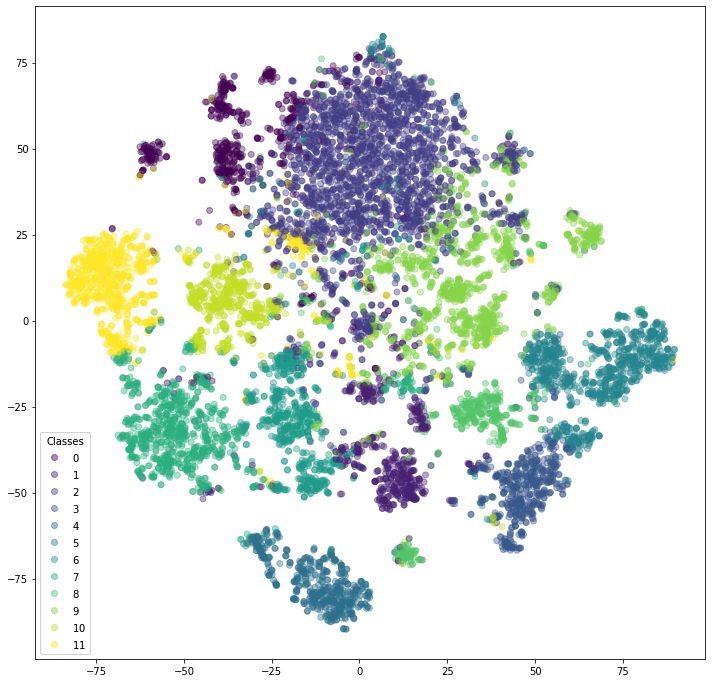

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(
    emb_tsne["X0"],
    emb_tsne["X1"],
    alpha=0.4,
    c=clustering.labels_
)
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()


In [ ]:
"""
Patient Clusters (12)- 
    0 intestinal/bowel/metabolic
    1 CKD + CHF
    2 ulcer of skin, multiple sclerosis
    3 stroke, seizures, paralysis
    4 heart, vascular, diabetes
    5 cancers, immunity disorder
    6 brain haemmorrage, head spinal chord injuries
    7 cancer, immunity, artificial openings
    8 mental diseases
    9 ckd kidney
    10 vascular, copd, pneumonia, lung infections
    11 ami, diabetes
"""

In [51]:
emb_tsne.reset_index().merge(trainer.node_labels.reset_index(), how='left')

,empi,X0,X1,cluster_id,1.0,2.0,6.0,8.0,9.0,10.0,...,162.0,166.0,167.0,169.0,170.0,173.0,176.0,186.0,188.0,189.0
0,M0000040556,43.918732,-64.963615,6,0,0,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0
1,M0003299846,-59.424480,46.892632,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M0005129001,39.821987,-27.840162,2,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,M0014789603,-77.091606,14.668893,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M0023249300,29.861080,-24.729649,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11172,M9993964586,64.456024,-16.840725,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11173,M9994944874,49.449718,-42.840702,6,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
11174,M9995442100,-2.539352,-13.349977,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11175,M9997352040,-15.446548,60.907806,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
emb_tsne['cluster_id'] = clustering.labels_

In [53]:
emb_tsne_features = emb_tsne.reset_index().merge(trainer.node_labels.reset_index().rename({"":"empi"}, axis=1), how='left')
emb_tsne_features = emb_tsne_features.groupby('cluster_id').agg('sum').drop(["X0","X1"], axis=1)

In [54]:
def apply_softmax(s):
    return round(np.exp(s) / np.exp(s).sum(), 4)

In [55]:
top_columns = emb_tsne_features.sum().sort_values()[30:]

In [56]:
hcc_clusters = emb_tsne_features[top_columns.index].apply(apply_softmax, axis=0)

In [57]:
emb_tsne_features = emb_tsne_features / emb_tsne_features.sum()

In [58]:
emb_tsne_features = emb_tsne_features[top_columns.index]

In [78]:
hcc_clusters

,6.0,157.0,189.0,17.0,35.0,75.0,170.0,77.0,106.0,134.0,...,135.0,108.0,19.0,9.0,12.0,111.0,18.0,2.0,96.0,85.0
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.0000,0.000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0001,0.982,0.0,0.0,0.0003,0.0000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0003,0.000,0.0,0.0,0.1138,0.0474,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0024,0.000,0.0,0.0,0.0003,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0066,0.000,1.0,0.0,0.0000,0.0000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0000,0.000,0.0,0.0,0.0021,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0000,0.000,0.0,1.0,0.0000,0.0000,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0001,0.000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8,0.9860,0.000,0.0,0.0,0.8409,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
emb_tsne_features

,6.0,157.0,189.0,17.0,35.0,75.0,170.0,77.0,106.0,134.0,...,135.0,108.0,19.0,9.0,12.0,111.0,18.0,2.0,96.0,85.0
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.021277,0.021277,0.031746,0.029851,0.072464,0.000000,0.012658,0.000000,...,0.041731,0.220423,0.026022,0.006158,0.015091,0.036332,0.018137,0.017397,0.034807,0.024380
1,0.046512,0.446809,0.148936,0.021277,0.079365,0.014925,0.014493,0.066667,0.101266,0.034091,...,0.170015,0.053549,0.029740,0.013547,0.015091,0.028547,0.032976,0.267223,0.025967,0.046323
2,0.069767,0.000000,0.085106,0.085106,0.174603,0.238806,0.159420,0.040000,0.037975,0.011364,...,0.086553,0.089664,0.164808,0.029557,0.076459,0.074394,0.085738,0.093946,0.102210,0.070297
3,0.116279,0.021277,0.021277,0.000000,0.079365,0.074627,0.000000,0.213333,0.012658,0.011364,...,0.049459,0.042341,0.038414,0.663793,0.056338,0.061419,0.026381,0.066110,0.027072,0.024380
4,0.139535,0.042553,0.404255,0.085106,0.031746,0.014925,0.028986,0.013333,0.240506,0.909091,...,0.083462,0.097136,0.052045,0.016010,0.016097,0.032872,0.150866,0.078636,0.040331,0.111743
5,0.023256,0.000000,0.000000,0.085106,0.111111,0.089552,0.086957,0.053333,0.012658,0.000000,...,0.085008,0.073474,0.065675,0.102217,0.622736,0.053633,0.038747,0.096033,0.050276,0.040228
6,0.000000,0.063830,0.170213,0.446809,0.000000,0.029851,0.043478,0.013333,0.430380,0.011364,...,0.114374,0.148194,0.343247,0.023399,0.033199,0.062284,0.443528,0.060543,0.056354,0.080049
7,0.046512,0.021277,0.021277,0.021277,0.000000,0.014925,0.057971,0.026667,0.050633,0.022727,...,0.105100,0.079701,0.059480,0.012315,0.026157,0.089100,0.051113,0.072373,0.104420,0.388866
8,0.255814,0.021277,0.000000,0.021277,0.206349,0.074627,0.057971,0.040000,0.000000,0.000000,...,0.034003,0.041096,0.016109,0.045567,0.051308,0.022491,0.014839,0.045929,0.012707,0.017879


In [59]:
 cluster_id = 0
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # AMI, vd

cluster_id    0
88.0        1.0
87.0        1.0
86.0        1.0
108.0       1.0
6.0         0.0


88.0     0.379032
87.0     0.322222
86.0     0.265664
108.0    0.220423
167.0    0.122807
Name: 0, dtype: float64

In [60]:
 cluster_id = 1
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # sever hematological disorders, ulcer, sepsis

cluster_id      1
46.0        1.000
2.0         1.000
135.0       1.000
158.0       1.000
157.0       0.982


46.0     0.609756
157.0    0.446809
158.0    0.386139
2.0      0.267223
159.0    0.192308
Name: 1, dtype: float64

In [61]:
 cluster_id = 2
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # stroke, paralysis

cluster_id       2
103.0       1.0000
40.0        1.0000
23.0        1.0000
100.0       1.0000
33.0        0.8808


103.0    0.368580
100.0    0.366265
40.0     0.317073
23.0     0.301587
33.0     0.244966
Name: 2, dtype: float64

In [62]:
 cluster_id = 3
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # copd, pneumonia, heart

cluster_id       3
9.0         1.0000
28.0        1.0000
6.0         0.0024
35.0        0.0003
176.0       0.0000


9.0     0.663793
28.0    0.304348
8.0     0.289225
77.0    0.213333
47.0    0.197917
Name: 3, dtype: float64

In [63]:
 cluster_id = 4
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # ckd, implants

cluster_id       4
176.0       1.0000
189.0       1.0000
134.0       1.0000
136.0       1.0000
39.0        0.1554


134.0    0.909091
136.0    0.907200
176.0    0.408421
189.0    0.404255
106.0    0.240506
Name: 4, dtype: float64

In [64]:
 cluster_id = 5
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # cancer

cluster_id       5
11.0        1.0000
12.0        1.0000
8.0         1.0000
35.0        0.0021
52.0        0.0000


11.0     0.627863
12.0     0.622736
8.0      0.508507
188.0    0.178571
47.0     0.177083
Name: 5, dtype: float64

In [65]:
 cluster_id = 6
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # diabetes, ulceration

cluster_id    6
17.0        1.0
18.0        1.0
161.0       1.0
106.0       1.0
137.0       1.0


161.0    0.464103
17.0     0.446809
18.0     0.443528
106.0    0.430380
19.0     0.343247
Name: 6, dtype: float64

In [67]:
 cluster_id = 7
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # CHF

cluster_id       7
6.0         0.0001
52.0        0.0000
48.0        0.0000
33.0        0.0000
103.0       0.0000


85.0     0.388866
137.0    0.150442
86.0     0.127820
84.0     0.117647
135.0    0.105100
Name: 7, dtype: float64

In [68]:
 cluster_id = 8
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # lymphoma, immune

cluster_id      8
48.0        1.000
10.0        1.000
47.0        1.000
107.0       1.000
6.0         0.986


10.0     0.590022
47.0     0.328125
6.0      0.255814
107.0    0.248718
35.0     0.206349
Name: 8, dtype: float64

In [69]:
 cluster_id = 9
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # mental diseases

cluster_id    9
114.0       1.0
159.0       1.0
167.0       1.0
51.0        1.0
169.0       1.0


78.0    0.681416
52.0    0.663793
51.0    0.637168
59.0    0.589011
77.0    0.506667
Name: 9, dtype: float64

In [70]:
 cluster_id = 10
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # copd, pneumonia

cluster_id      10
111.0       1.0000
112.0       1.0000
84.0        1.0000
115.0       0.1192
6.0         0.0024


111.0    0.444637
84.0     0.327059
112.0    0.255319
115.0    0.166667
114.0    0.138655
Name: 10, dtype: float64

In [71]:
 cluster_id = 11
 print(hcc_clusters[hcc_clusters.index==cluster_id].T.sort_values(cluster_id, ascending=False).head())
 emb_tsne_features.iloc[cluster_id,:].sort_values(ascending=False).head() # specified heart arythmias

cluster_id      11
6.0         0.0009
35.0        0.0008
52.0        0.0000
48.0        0.0000
33.0        0.0000


96.0     0.444199
35.0     0.095238
6.0      0.093023
115.0    0.092593
48.0     0.087591
Name: 11, dtype: float64

In [127]:
hcc_weights = pd.read_csv(hcc_weights_fp)

In [11]:
hcc_weights

,hcc,weight,cat
0,1,0.492,CAT-1
1,2,0.520,CAT-2
2,6,0.557,CAT-3
3,8,2.425,CAT-4
4,9,1.006,CAT-4
...,...,...,...
82,176,0.555,CAT-37
83,186,1.032,CAT-38
84,188,0.609,CAT-38
85,189,0.804,CAT-39
